# Playing with Pre-Trained Word Embeddings

In this notebook we'll play a bit with word embeddings pre-trained on the Google News corpora. Given training a Word2Vec model is quite expensive both in time and resources, it is very likelly that we'll need to leverage pre-trained models as this. 

In essence this pre-trained model is just a big lookup table that links words to their vector representation.

Word embeddings are a very powerful tool in the world of Natural Language Processing and are often used as a preprocessing step for text.

## Before starting...

Let's import all the libraries we'll need beforehand. Most of the code we'll use is in the `helpers.py` script. Eventually I'll show some functions using the `inspect` library.

In [1]:
%matplotlib inline

from helpers import *
import inspect
import gensim
import matplotlib as plt
from IPython.core.pylabtools import figsize

figsize(20, 20)

Using TensorFlow backend.


## Finding word similarity using a pre-trained model

We want to determine which words are similar between them. We can achieve this using a pre-trained model. 

First, we need to download the Google News model. The name of that model is as follows:

In [2]:
MODEL

'GoogleNews-vectors-negative300.bin'

To download it, we'll first fetch it using the `get_file` function from Keras and then unzipping it into a predefined location:

In [3]:
print(inspect.getsource(unzip_file))

def unzip_file(input_zipped_file, destination):
    if not os.path.isdir(destination):
        with open(destination, 'wb') as fout:
            zcat = subprocess.Popen(['zcat'], stdin=open(input_zipped_file), stdout=fout)
            zcat.wait()



In [4]:
print(inspect.getsource(download_google_news_model))

def download_google_news_model(destination='generated'):
    unzipped_destination_file = os.path.join(destination, MODEL)
    if not os.path.exists(unzipped_destination_file):
        # get_file won't download the file twice if it finds it in its cache
        path = get_file(f'{MODEL}.gz', f'https://s3.amazonaws.com/dl4j-distribution/{MODEL}.gz')

        if not os.path.isdir(destination):
            os.mkdir(destination)

        unzip_file(path, unzipped_destination_file)

    return unzipped_destination_file



In [5]:
# First, let's download the model.
unzipped = download_google_news_model()

# Then, let's create a Word2Vec model using the downloaded parameters.
gnews_model = gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)

The model is quite heavy (around 3.5 GB). We can use it to look for words similar to another. For that matter we'll use the following function:

In [6]:
print(inspect.getsource(get_most_similar_terms))

def get_most_similar_terms(model, terms):
    assert isinstance(terms, str) or isinstance(terms, list)

    terms = [terms] if isinstance(terms, str) else terms

    return model.most_similar(positive=terms)



In [7]:
get_most_similar_terms(gnews_model, 'bike')

/Users/jesusmartinez/miniconda3/envs/text-similarity/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('bicycle', 0.8521308898925781),
 ('bikes', 0.8127913475036621),
 ('mountain_bike', 0.7518468499183655),
 ('scooter', 0.7495757937431335),
 ('motorcycle', 0.7016158103942871),
 ('Bike', 0.7006312608718872),
 ('biking', 0.6792795658111572),
 ('BMX_bike', 0.6724931597709656),
 ('bicycles', 0.670872688293457),
 ('moped', 0.642906665802002)]

The magic of Word2Vec is that it places the vectors associated to similar words near each other in the n-dimesional space that contains them. Hence, finding similar words is just a nearest-neighbor search.

## Arithmetic in Word2Vec world

The great thing about the vectors that Word2Vec use to represent words are just that, vectors, an as such we can apply arithmetic operations on them. 

What's really impressive about this is that these operations have a meaning! For instance, we can use this to find relationships of the type "what relates to King the way Son relates to Daughter?".

The following function allow us to do that:

In [8]:
print(inspect.getsource(a_is_to_b_as_c_is_to))

def a_is_to_b_as_c_is_to(model, a, b, c, top_n=1):
    # Ensures a, b and c are lists.
    a, b, c = map(lambda x: x if isinstance(x, list) else [x], (a, b, c))

    positives = b + c
    negatives = a
    results = model.most_similar(positive=positives, negative=negatives, topn=top_n)

    if len(results) > 0:
        if top_n == 1:
            return results[0][0]  # Return single element
        else:
            return [result[0] for result in results]

    return None



In [9]:
a_is_to_b_as_c_is_to(gnews_model, 'man', 'woman', 'king')

'queen'

We can also use this function to find the capitals of other countries based on a sample relationship:

In [10]:
for country in {'Italy', 'China', 'Venezuela', 'Colombia'}:
    print(f'{a_is_to_b_as_c_is_to(gnews_model, "Germany", "Berlin", country)} is the capital of {country}.')

Beijing is the capital of China.
Caracas is the capital of Venezuela.
Rome is the capital of Italy.
Bogotá is the capital of Colombia.


Or to find the main products of well-known companies:

In [11]:
for company in {'Google', 'IBM', 'Boeing', 'Microsoft', 'Walmart', 'Tesla'}:
    products = a_is_to_b_as_c_is_to(gnews_model, ['Starbucks', 'Apple'], ['Starbucks_coffee', 'iPhone'], company, top_n=3)
    print(f'{company} -> {", ".join(products)}')

Boeing -> Dreamliner, airframe, aircraft
IBM -> DB2, WebSphere_Portal, Tamino_XML_Server
Walmart -> WalMart, Wal_Mart_Supercenter, Wal_mart
Microsoft -> Windows_Mobile, SyncMate, Windows
Tesla -> Tesla_Roadster, supercar, Roadster
Google -> personalized_homepage, app, Gmail


## Visualizing word embeddings

Trying to picture high-dimensional vectors is always a challenge. Fortunatelly, we can use the TSNE algorithm to project down these embeddings to a more familiar 2D space, while preserving the order and spacial coherence of the vectors. 

The best way to see this process in action is to have clearly defined clusters. Let's define them:

In [12]:
beverages = ['espresso', 'beer', 'vodka', 'wine', 'cola', 'tea']
countries = ['Italy', 'Spain', 'Canada', 'Russia', 'USA', 'Argentina', 'Venezuela', 'Colombia']
sports = ['soccer', 'handball', 'basketball', 'hockey', 'cycling', 'cricket', 'baseball']
animals = ['dog', 'cat', 'parrot', 'seahorse', 'zebra', 'rhino', 'elephant', 'cheetah']
    
items = beverages + countries + sports + animals
print(f'Number of items: {len(items)}')

Number of items: 29


Now, we just need to:

 - Look up the vector associated with each item.
 - Normalize the vectors.
 - Use TSNE to find the clusters we expect in a 300-dimensional space.
 - Plot each item in a 2D space.

def visualize_word_embeddings(model, items):
    # Remember that, basically, a model is just a big lookup table from words to vectors.
    item_vectors = np.asarray([model[item] for item in items if item in model])

    # Normalize vectors.
    lengths = np.linalg.norm(item_vectors, axis=1)
    norm_vectors = (item_vectors.T / lengths).T

    tsne = TSNE(n_components=2, perplexity=10, verbose=2).fit_transform(norm_vectors)

    xs = tsne[:, 0]
    ys = tsne[:, 1]

    _, ax = plt.subplots()
    ax.scatter(xs, ys)  # Place points on canvas

    for item, x, y in zip(items, xs, ys):
        ax.annotate(item, (x, y), size=14)  # Annotate each point with the word it represents

    plt.show()

[t-SNE] Computing 28 nearest neighbors...
[t-SNE] Indexed 29 samples in 0.001s...
[t-SNE] Computed neighbors for 29 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 29 / 29
[t-SNE] Mean sigma: 0.507128
[t-SNE] Computed conditional probabilities in 0.015s
[t-SNE] Iteration 50

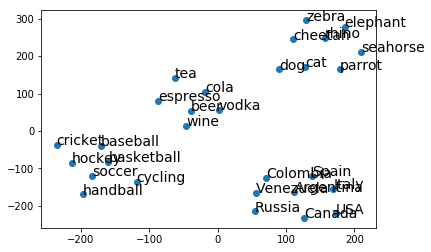

In [13]:
print(inspect.getsource(visualize_word_embeddings))

# Expectation: We should see four clear clusters, one for beverages, one for animals, one for countries and one for sports.
visualize_word_embeddings(gnews_model, items)

In the TSNE algorithm the perplexity parameter loosely determines the balance between local accuracy and overall accuracy. Giving it a low value creates small clustersthat are locally accurate, while setting it to a larger value yields more local distortions, but with better clusters, overall.